In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
from pymongo import MongoClient
from spacy.en import English

In [3]:
client = MongoClient('localhost', 27017)
db = client.python_import
collection = db.earnings_transcript

In [4]:
transcripts = pd.DataFrame(list(collection.find().limit(50)))

In [5]:
transcripts.head(1)

,_id,date_number,h_tone,publishDate,qAndAText,q_and_a_h_tone,q_and_a_wordSize,rawText,time_number,tradingSymbol,url,wordSize
0,5937dba3082789410c746a1e,1130423,"{'positiveCount': 203, 'negativeCount': 75}",2013-04-23 21:30:07,Operator [Operator Instructions] We'll go firs...,"{'positiveCount': 117, 'negativeCount': 46}",7493,US Airways Group ( LCC ) Q1 2013 Earnings Call...,213007,AAL,https://seekingalpha.com/article/1363811-us-ai...,11310


In [6]:
nlp = English()

In [7]:
text = transcripts.iloc[0]['rawText']

In [8]:
doc = nlp(text)

In [9]:
len(doc)

11391

In [10]:
for i in range(20):
    print(str(doc[i]) + '\t\t' + str(doc[i].lemma_))

US		us
Airways		airways
Group		group
(		(
LCC		lcc
)		)
Q1		q1
2013		2013
Earnings		earning
Call		call
April		april
23		23
,		,
2013		2013
12:30		12:30
PM		pm
ET		et
Executives		executives
Daniel		daniel
Cravens		cravens


In [11]:
import textacy

In [12]:
ranked = textacy.keyterms.sgrank(
    doc,
    normalize='lemma',
    ngrams = (2,3,4,5),
    n_keyterms=200,
)

In [18]:
ranked[:20]

[('buckingham research group incorporated', 0.22422951075122935),
 ('j. scott kirby', 0.1814021539446511),
 ('william douglas parker', 0.11181998851989701),
 ('derek j. kerr', 0.0593143512940076),
 ('bofa merrill lynch', 0.04463834448420273),
 ('glenn d. engel', 0.04344146038058111),
 ('robert d. isom', 0.0384018482614768),
 ('hunter k. keay', 0.035662464611214174),
 ('jp morgan chase', 0.03470658052222822),
 ('jamie n. baker', 0.03365279253216624),
 ('john d. godyn', 0.03338266619859783),
 ('research division', 0.022704861610778507),
 ('fuel price', 0.01536364306097041),
 ('low fuel price', 0.010454160468751215),
 ('special item', 0.007637661492688125),
 ('fourth quarter', 0.007574028775364999),
 ('savanthi syth', 0.007232144359557934),
 ('revenue environment', 0.007222965221552363),
 ('operator instructions', 0.006692683680558231),
 ('raymond james', 0.006689476579442346)]

Populating the interactive namespace from numpy and matplotlib


C:\ProgramData\Anaconda3\lib\site-packages\IPython\core\magics\pylab.py:160: UserWarning: pylab import has clobbered these variables: ['text']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


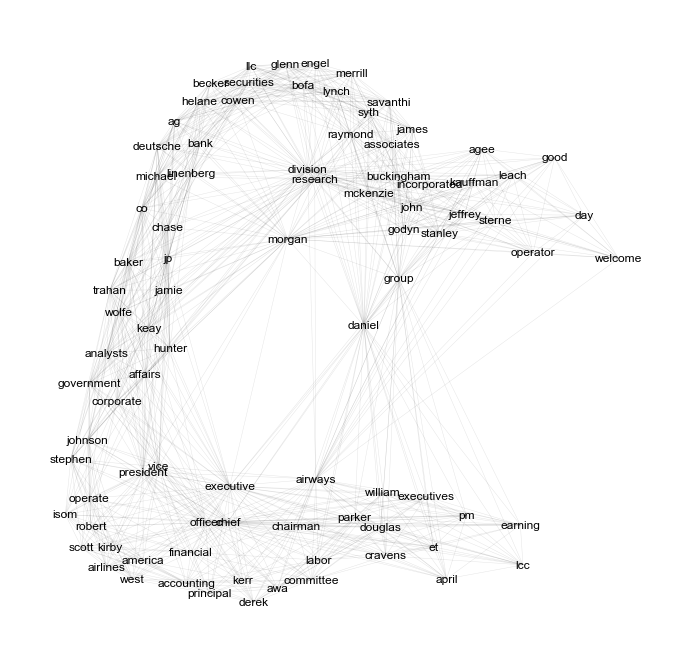

In [14]:
%pylab inline
textacy.viz.draw_semantic_network(
    textacy.keyterms.terms_to_semantic_network(
        [tok for tok in doc[:200] if not tok.is_stop and tok.pos_ in ["NOUN", "PROPN", "ADJ", "VERB"] and tok.is_alpha],
        normalize='lemma',
        edge_weighting='cooc_freq',
        window_width=15
    )
)

In [15]:
from textacy.text_utils import keyword_in_context

keyword_in_context(doc.text, "morgan", window_width=50)

 K. Keay - Wolfe Trahan & Co. Jamie N. Baker - JP  Morgan  Chase & Co, Research Division Michael Linenberg -
ngham Research Group Incorporated John D. Godyn -  Morgan  Stanley, Research Division Jeffrey A. Kauffman - 
we'll go next to Jamie Baker. Jamie N. Baker - JP  Morgan  Chase & Co, Research Division Scott, even before 
ot always a straight line up. Jamie N. Baker - JP  Morgan  Chase & Co, Research Division Okay, that's helpfu
eeing strengths in that line. Jamie N. Baker - JP  Morgan  Chase & Co, Research Division And any additional 
hat we can't [indiscernible]. Jamie N. Baker - JP  Morgan  Chase & Co, Research Division Okay. Yes, yes. Der
ator We'll go next to John Godyn. John D. Godyn -  Morgan  Stanley, Research Division Scott, I wanted to ask
 lot easier to keep pricing firm. John D. Godyn -  Morgan  Stanley, Research Division Well, if we imagined a
he economy and good for airlines. John D. Godyn -  Morgan  Stanley, Research Division That's really helpful.


In [21]:
import math
from collections import Counter 
words = [tok for tok in doc if tok.is_alpha and not tok.is_stop and tok.pos_ in ["NOUN", "VERB", "ADJ", "PROPN"]]
word_probs = {tok.text.lower(): tok.prob for tok in words}

freqs = Counter(tok.text for tok in words)
word_scores = {tok: freqs[tok] for tok, prob in word_probs.items()}

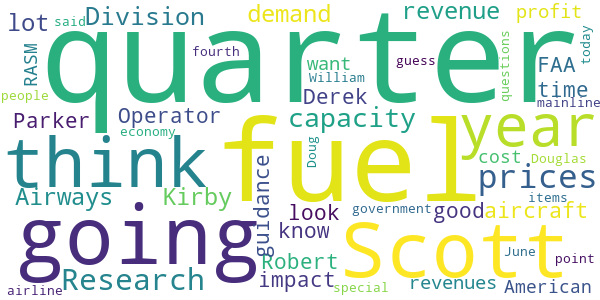

In [22]:
from wordcloud import WordCloud

wordcloud = WordCloud(background_color="white", max_words=50, scale=1.5).generate_from_frequencies(freqs)
image = wordcloud.to_image()
image.save("./wordcloud.png")
from IPython.display import Image 
Image(filename='./wordcloud.png')